<a href="https://colab.research.google.com/github/BhavikBuchke/ML-Regression-Workshops/blob/main/Automotive%20Market%20Analysis/automobile%20price%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Prerequisites**

In [1]:
# Install required libraries (not in Colab)
# Uncomment below lines to install required libraries.


# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [2]:
# Importing required libraries

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

In [31]:
# Defining required functions.
def model_metrics(regressor, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print("Root mean squared error: %.2f" % math.sqrt(mse))
    r2 = r2_score(y_test, y_pred)
    print('R2 score: %.2f' % r2)
    return [mse, r2]

def plot_metrics(X_test, y_test, y_pred):
    sns.set_style("darkgrid")
    plt.figure(figsize=(8, 6))
    plt.suptitle(model_name + '. Variance score: %.2f' % r2_score(y_test, y_pred))

    sns.scatterplot(x=X_test, y=y_test, color='yellowgreen', label='Actual')
    sns.scatterplot(x=X_test, y=y_pred, color='orangered', label='Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel(X_test.name)
    plt.ylabel('Price')
    plt.legend()

### **Section 1: Project Objective & Data Profiling**

*We begin our analysis by defining the core objective: building a predictive model to estimate the market price of used automobiles based on their technical specifications and usage history. High-quality automated valuation models are essential for scaling a resale business efficiently.*

In [5]:
#load data
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/exN-VGWhy9OjnXIevpKh5g/cars.csv')
df.head()

,Car_ID,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,1,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5,800000
1,2,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5,1000000
2,3,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4,2500000
3,4,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5,600000
4,5,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5,850000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Car_ID             100 non-null    int64 
 1   Brand              100 non-null    object
 2   Model              100 non-null    object
 3   Year               100 non-null    int64 
 4   Kilometers_Driven  100 non-null    int64 
 5   Fuel_Type          100 non-null    object
 6   Transmission       100 non-null    object
 7   Owner_Type         100 non-null    object
 8   Mileage            100 non-null    int64 
 9   Engine             100 non-null    int64 
 10  Power              100 non-null    int64 
 11  Seats              100 non-null    int64 
 12  Price              100 non-null    int64 
dtypes: int64(8), object(5)
memory usage: 10.3+ KB


In [7]:
# Checking empty/Null values.
df.isnull().any()

,0
Car_ID,False
Brand,False
Model,False
Year,False
Kilometers_Driven,False
Fuel_Type,False
Transmission,False
Owner_Type,False
Mileage,False
Engine,False


**Data integrity is the foundation of any predictive model. Our initial profiling shows a clean dataset of 100 records with no missing values. We have a mix of numerical features, such as Mileage and Power, and categorical features, such as Brand and Fuel_Type.**

In [8]:
# Removing unnecessary columns
df = df.drop(['Car_ID'], axis=1)
df.columns

Index(['Brand', 'Model', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price'],
      dtype='object')

### **Section 2: Preprocessing Strategy**

*To make this raw data compatible with machine learning algorithms, we implement a robust preprocessing pipeline. We use One-Hot Encoding to transform categorical variables into binary format, allowing the model to interpret brand and transmission types. Simultaneously, we apply a Standard Scaler to numerical features to normalize their range, ensuring that high-magnitude values like Kilometers_Driven do not disproportionately bias the model's coefficients.*

In [9]:
# Defining the categorical columns

catCols = df.select_dtypes(include=['object']).columns
print(f'Categorical columns:\n{catCols}')

onehot_categorical = OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('onehot', onehot_categorical)])

# Defining the numerical columns
numCols = [col for col in df.select_dtypes(include=['float', 'int']).columns if col not in ['Price']]
print(f'Numerical columns:\n{numCols}')

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale', scaler_numerical)])

# preprocessor for categorical and numerical columns

preprocessor_calCols = ColumnTransformer(transformers=[('cat', categorical_transformer, catCols)],
                                            remainder="passthrough")
preprocessor_AllCols = ColumnTransformer(transformers=[('cat', categorical_transformer, catCols),
                                          ('num',numerical_transformer,numCols)],remainder="passthrough")

Categorical columns:
Index(['Brand', 'Model', 'Fuel_Type', 'Transmission', 'Owner_Type'], dtype='object')
Numerical columns:
['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']


### **Section 3: Model Selection & Training**

*We partition our data into training and testing sets to ensure we are measuring the model's ability to generalize to unseen data rather than just memorizing the training samples. We have selected two distinct modeling approaches for comparison: a baseline Multiple Linear Regression and a more complex Random Forest Regressor ensemble.*

In [10]:
# Preparing data for machine learning (Regration) by creating Features and lables.

features = []
features = df.drop(['Price'], axis=1)

label = pd.DataFrame(df, columns=['Price'])
label = df['Price']

# Spliting the data

X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=42)

### **Section 4: Performance Evaluation & Insights**

*Our evaluation provides clear insights into the predictive power of our features.*

    Multiple Linear Regression achieved an R2 score of 0.91, indicating 91% of the variance in car prices.

    Random Forest followed with a score of 0.88.

*Interestingly, the simpler Linear Regression model outperformed the Random Forest here, likely because the primary relationships—such as the inverse correlation between age/mileage and price—are significantly linear in this specific dataset.*

*To find the most accurate pricing tool, we didn't just pick one model; we conducted an experiment between two fundamentally different approaches.*

**1. Multiple Linear Regression:** We chose this as our baseline. It assumes a direct, 'linear' relationship—for example, as the year of the car decreases, the price drops at a steady rate.

In [11]:
from sklearn.linear_model import LinearRegression

model_name = 'Multiple Linear Regression'
mlRegressor = LinearRegression()
ml_model = Pipeline(steps=[('preprocessorAll', preprocessor_AllCols), ('regressor', mlRegressor)])
ml_model.fit(X_train, y_train)
y_pred_ml = ml_model.predict(X_test)

print(f'Model name: {mlRegressor}\nIntercept: {mlRegressor.intercept_}\nCoefficients: \n{mlRegressor.coef_}')

Model name: LinearRegression()
Intercept: 1574386.423005438
Coefficients: 
[ 387101.74765877  494120.47341866 -200146.33075846 -190062.97321051
 -129517.13391069 -373643.31957998 -154826.64252538  425492.65127826
 -146734.80043087  105993.25610492 -217776.9280447   -77597.89634278
  334219.75786002  141028.22258445 -342752.81147563   46411.16920672
  553128.84846189   16406.8208045  -238869.45344042  119719.56304166
  -89779.7072838   222108.33424382  208655.23010073   17005.60649774
  -64048.0573978    27753.47359521    8266.66533703  219938.34293621
  123696.54028003  -64273.81863614  439852.97034679  -39775.64277225
 -268384.07724281  483790.56345428 -142382.62651446 -220278.10906911
 -322236.83527349 -580931.28945383   41940.52939889 -183429.87077164
 -131240.99932539  -26965.33395296   16251.65283431   97134.20601661
 -328181.855763    -73601.73785094   83351.17992749 -340573.62083075
   26580.95206053   81008.88341596   10902.21373113  246042.87549904
   89720.51999372   36172.92

In [12]:
ml_Metrics = model_metrics(mlRegressor, y_test, y_pred_ml)

Root mean squared error: 302448.62
R2 score: 0.91


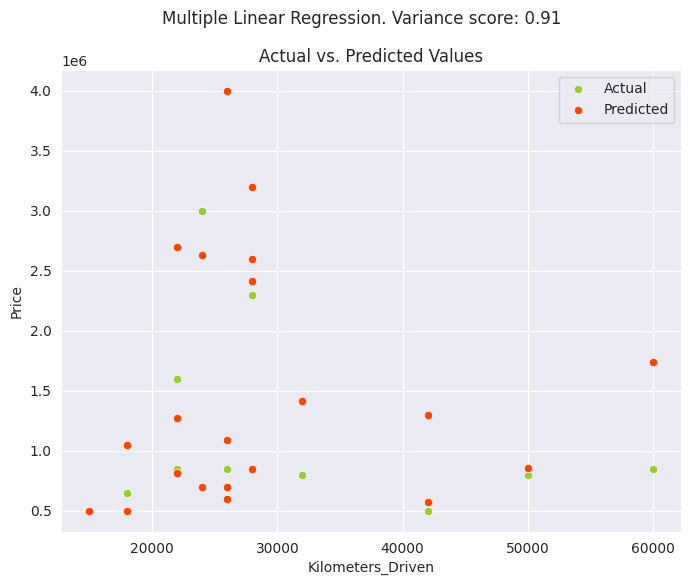

In [13]:
plot_metrics(X_test['Kilometers_Driven'], y_test, y_pred_ml)

**2. Random Forest Regressor:** This is a more complex 'ensemble' model. It works like a committee of decision trees that look for patterns that aren't just straight lines, which is often how real-world car markets behave.

In [14]:
from sklearn.ensemble import RandomForestRegressor

model_name = "Random Forest Regressor"
rf_Regressor = RandomForestRegressor(n_estimators=90, max_depth=10, random_state=1)
rf_model = Pipeline(steps=[('preprocessorAll', preprocessor_AllCols), ('regressor', rf_Regressor)])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_Metrics = model_metrics(rf_Regressor, y_test, y_pred_rf)

Root mean squared error: 343186.40
R2 score: 0.88


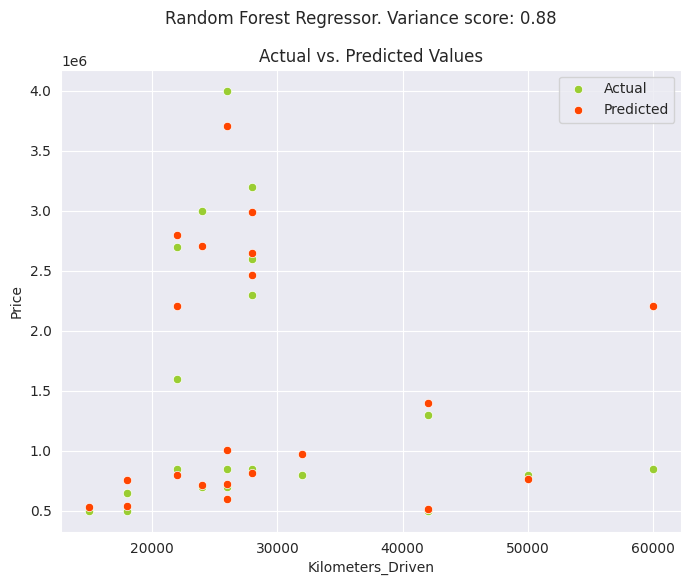

In [15]:
plot_metrics(X_test['Kilometers_Driven'], y_test, y_pred_rf)

### **Section 5: Competitive Model Analysis**

*To determine the most effective predictive tool, we performed a head-to-head comparison between two different modeling philosophies:*

1. **Multiple Linear Regression:** This model serves as our baseline. It seeks to find a linear relationship between the multiple features (such as car age, mileage, and engine power) and the target price. It is highly interpretable and efficient.

2. **Random Forest Regressor:** This is an ensemble learning method that builds multiple decision trees. It is designed to capture complex, non-linear patterns and interactions that a standard linear model might miss.

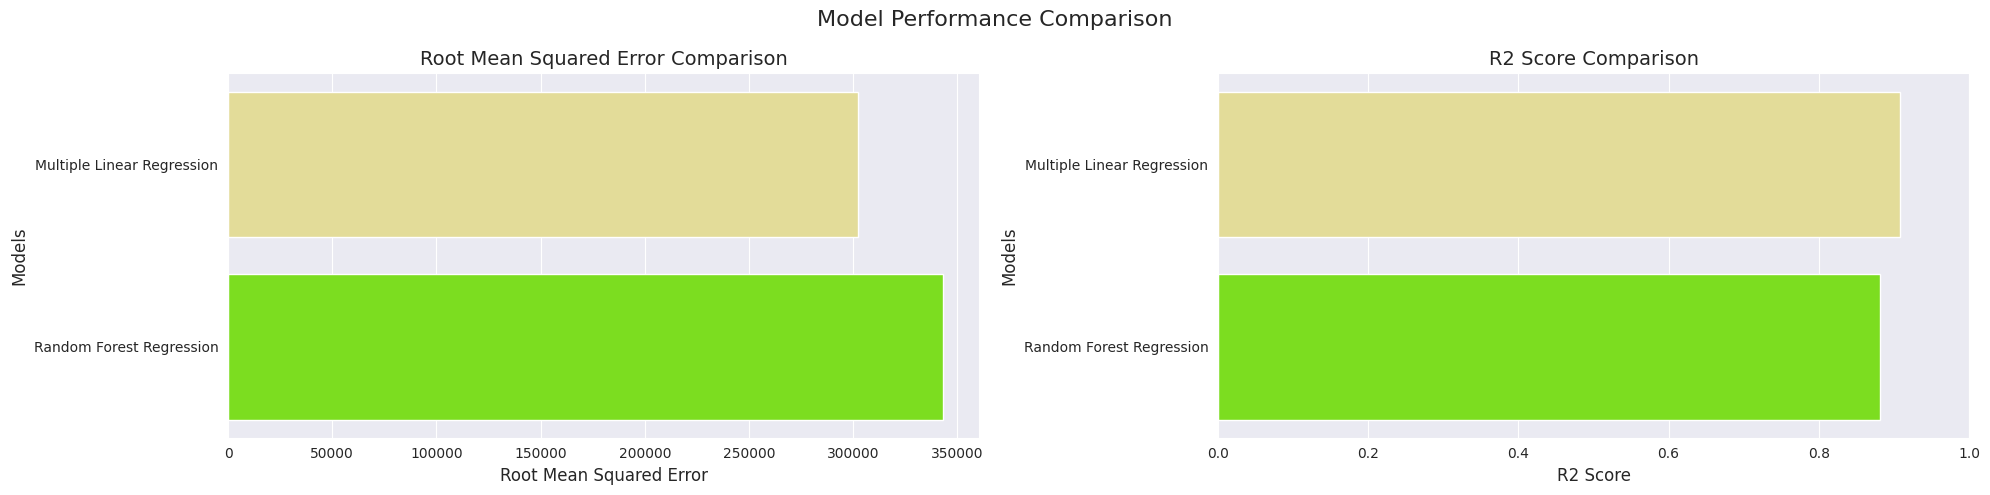

In [30]:
n_groups = 1
index = np.arange(n_groups)
bar_width = 1
opacity = 0.8

# Prepare data for seaborn bar plots
model_labels = ['Multiple Linear Regression', 'Random Forest Regression']
rmse_values = [math.sqrt(ml_Metrics[0]), math.sqrt(rf_Metrics[0])]
r2_values = [ml_Metrics[1], rf_Metrics[1]]

rmse_df = pd.DataFrame({'Model': model_labels, 'Root MSE': rmse_values})
r2_df = pd.DataFrame({'Model': model_labels, 'R2 Score': r2_values})

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
fig.suptitle('Model Performance Comparison', fontsize=16)

# First subplot (Root MSE comparison)
sns.barplot(x='Root MSE', y='Model', data=rmse_df, palette=['khaki', 'lawngreen'], ax=ax1)
ax1.set_xlabel('Root Mean Squared Error', fontsize=12)
ax1.set_ylabel('Models', fontsize=12)
ax1.set_title('Root Mean Squared Error Comparison', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_xlim(left=0)

# Second subplot (R2 comparison)
sns.barplot(x='R2 Score', y='Model', data=r2_df, palette=['khaki', 'lawngreen'], ax=ax2)
ax2.set_xlabel('R2 Score', fontsize=12)
ax2.set_ylabel('Models', fontsize=12)
ax2.set_title('R2 Score Comparison', fontsize=14)
ax2.tick_params(axis='y')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

### **Section 6: Interpreting the Performance Metrics**

*The performance metrics provide a clear indication of which model currently best fits the automobile market data:*

1. **R-Squared (R2):** Our Multiple Linear Regression model achieved a score of 0.91, outperforming the Random Forest (0.88). This indicates that the linear model explains 91% of the price variance.

2. **Root Mean Squared Error (RMSE):** The Multiple Linear Regression model maintained a lower error rate (302,448), confirming it as the more precise model for this specific dataset.

**Conclusion:** The fact that the Multiple Linear Regression model outperformed the more complex Random Forest suggests that the relationships between the features and car prices in this dataset are predominantly linear. The Random Forest likely requires a larger volume of data to reach its full predictive potential.